<a href="https://colab.research.google.com/github/Chameleon-company/MOP-Code/blob/Alen_T1_2025/cnn_lstm_sleep_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne wfdb scikit-learn matplotlib numpy pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
!pip install keras-tuner --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import mne
import wfdb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, LSTM, Dense, Dropout, TimeDistributed,
    Flatten, BatchNormalization, Bidirectional
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

# For hyperparameter tuning
import keras_tuner as kt



In [4]:
# Download from PhysioNet using WFDB
# Create directory
!mkdir -p sleep-edf

# Download PSG (EEG) and Hypnogram (annotations)
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
!wget -P sleep-edf https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf


--2025-04-30 06:41:21--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48338048 (46M) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001E0-PSG.edf’

SC4001E0-PSG.edf    100%[===================>]  46.10M   316KB/s    in 2m 30s  

2025-04-30 06:43:51 (315 KB/s) - ‘sleep-edf/SC4001E0-PSG.edf’ saved [48338048/48338048]

--2025-04-30 06:43:51--  https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4620 (4.5K) [application/octet-stream]
Saving to: ‘sleep-edf/SC4001EC-Hypnogram.edf’

SC4001EC-Hypnogram. 100%[===================>]   4.51K  --.-KB/s    in 0s      



In [5]:
subject_id = "SC4001E0"  # You can change this to test different subjects

# Load raw EEG and annotations
raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
annotations = mne.read_annotations(f"sleep-edf/{subject_id.replace('E0', 'EC')}-Hypnogram.edf")

raw.set_annotations(annotations)

# Focus on EEG channel
raw.pick_channels(['EEG Fpz-Cz'])

# Convert annotations to events
events, event_id = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=30, baseline=None, preload=True)

# Extract epoch data
data = epochs.get_data()

# Label mapping
stage_map = {
    'Sleep stage W': 0,
    'Sleep stage 1': 1,
    'Sleep stage 2': 2,
    'Sleep stage 3': 3,
    'Sleep stage 4': 3,  # Combine stage 3 and 4 as N3
    'Sleep stage R': 4
}

# Extract label names for each event using event_id
# Extract only valid sleep stage labels (ignore Sleep stage ?)
event_labels = [k for k in event_id.keys() if k.startswith("Sleep stage") and "?" not in k]

# Create mapping from MNE event IDs to stage_map codes
label_lookup = {
    event_id[label]: stage_map[label]
    for label in event_labels if label in stage_map
}


# Map MNE event codes to sleep stage values
labels = np.array([label_lookup[e[-1]] for e in events[:len(data)]])

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Extracting EDF parameters from /content/sleep-edf/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-5-6db4f04d84e5>:4: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
<ipython-input-5-6db4f04d84e5>:4: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)
<ipython-input-5-6db4f04d84e5>:4: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(f"sleep-edf/{subject_id}-PSG.edf", preload=True)


Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<ipython-input-5-6db4f04d84e5>:7: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
154 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 154 events and 3001 original time points ...
1 bad epochs dropped
Data shape: (153, 1, 3001)
Labels shape: (153,)


In [46]:
from sklearn.utils import class_weight

# Convert one-hot to single label
y_train_single = np.argmax(y_train, axis=1)

# Compute weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_single), y=y_train_single)
class_weights = dict(enumerate(weights))
print(class_weights)


{0: np.float64(2.033333333333333), 1: np.float64(1.22), 2: np.float64(0.8133333333333334), 3: np.float64(0.44363636363636366), 4: np.float64(4.88)}


In [47]:
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 425ms/step - accuracy: 0.0466 - loss: 1.7653 - val_accuracy: 0.0800 - val_loss: 1.6759
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 682ms/step - accuracy: 0.3859 - loss: 1.3113 - val_accuracy: 0.0800 - val_loss: 1.6828
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.4584 - loss: 1.1585 - val_accuracy: 0.0400 - val_loss: 1.6848
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 401ms/step - accuracy: 0.5850 - loss: 1.0979 - val_accuracy: 0.0800 - val_loss: 1.6812
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step - accuracy: 0.6411 - loss: 0.9278 - val_accuracy: 0.0800 - val_loss: 1.6619
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.7167 - loss: 0.8590 - val_accuracy: 0.0800 - val_loss: 1.6511
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 723ms/step - accuracy: 0.7604 - loss: 0.8068 - val_accuracy: 0.0800 - val_loss: 1.6424
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 406ms/step - accuracy: 0.7947 - loss: 0.7099 - val_accuracy: 0.1600 - val_loss

In [48]:
# Normalize each sample individually (better generalization)
X = data.squeeze()  # shape: (samples, time_points)

X_normalized = np.array([(x - np.mean(x)) / np.std(x) for x in X])

print("Before trim/reshape:", X_normalized.shape)

# Trim each sample to exactly 3000 time points
X_trimmed = np.array([x[:3000] for x in X_normalized if len(x) >= 3000])

# Reshape into (samples, 30 time steps, 100 features)
X = X_trimmed.reshape((X_trimmed.shape[0], 30, 100))

# Filter labels to match reshaped data
labels = labels[:len(X)]
y = to_categorical(labels, num_classes=5)

# Train-test split (keep raw test data for later)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_raw = X_test.copy()  # For visualizations or other models



Before trim/reshape: (153, 3001)


In [49]:
 def build_model(input_shape=(30, 100, 1), learning_rate=0.0005, filters=32, lstm_units=64, dropout_rate=0.5):
    model = Sequential([
        TimeDistributed(Conv1D(filters, kernel_size=3, activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        BatchNormalization(),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Build initial model with default parameters
model = build_model()

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_35             │ (None, 30, 98, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_36             │ (None, 30, 49, 32)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_37             │ (None, 30, 1568)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 30, 1568)       │         6,272 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 128)            │       836,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,077 (3.25 MB)

 Trainable params: 847,941 (3.23 MB)

 Non-trainable params: 3,136 (12.25 KB)

In [50]:
X_train = X_train.reshape((-1, 30, 100, 1))
X_test = X_test.reshape((-1, 30, 100, 1))

In [51]:
# After defining model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



✅ Test Accuracy: 0.10
✅ Test Loss: 1.6274


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


✅ Macro F1 Score: 0.0429

📄 Classification Report:
              precision    recall  f1-score   support

           W       0.00      0.00      0.00         0
          N1       0.00      0.00      0.00         4
          N2       0.17      0.30      0.21        10
          N3       0.00      0.00      0.00        16
         REM       0.00      0.00      0.00         1

    accuracy                           0.10        31
   macro avg       0.03      0.06      0.04        31
weighted avg       0.05      0.10      0.07        31



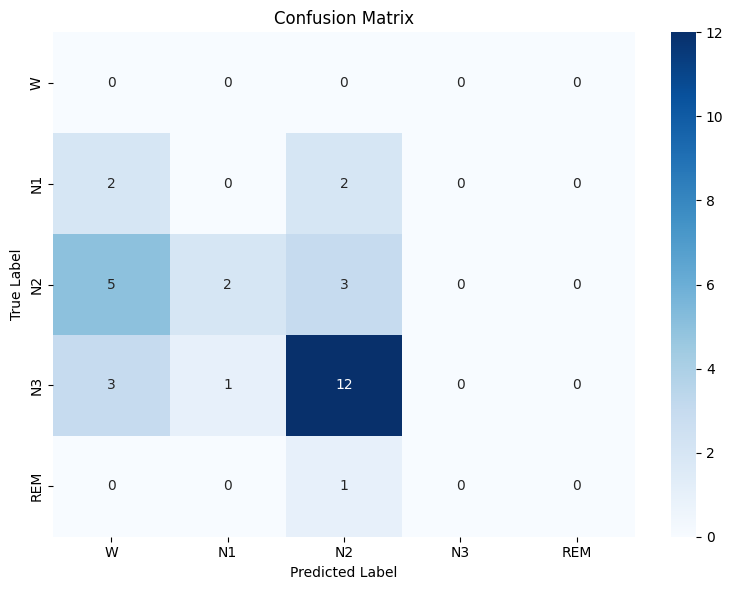

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Evaluate
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {accuracy:.2f}")
print(f"✅ Test Loss: {loss:.4f}")

# ✅ Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# ✅ F1 Score
f1 = f1_score(y_true, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")

# ✅ Classification Report
target_names = ["W", "N1", "N2", "N3", "REM"]
print("\n📄 Classification Report:")
print(classification_report(y_true, y_pred, labels=[0, 1, 2, 3, 4], target_names=target_names))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
